In [1]:
using Distributions
using Optim
using PyPlot

In [2]:
function enum_eq(eq,i,m)
    #enumerate all rationalizable equilibrium...
    new_eq = []
    if i==0
        return eq
    end
    
    for e=eq
        for as = 0:1:(m-1)
            new_e = append!(copy(e),as)
            append!(new_eq,[new_e])
        end
    end
    return enum_eq(new_eq,i-1,m)
end

enum_eq (generic function with 1 method)

In [3]:
function calc_loss(n, delta, eq)
    u = zeros(n)
    for i=1:n
        for j=1:(n-1)
            j_index = mod(i+j-1,n)+1
            u[i] =  u[i] + delta[i]*eq[j_index]
        end
    end
    return u
end

function utility(n, m, params, a, a_not, e, x)
    #set up params
    delta = params[1:n]
    beta = params[n+1:2*n]
    u = calc_loss(n, delta, a_not)
    x_re = reshape(x,(n,1))
    u = (u .+ beta.*x_re .-  a).* a
    for i=1:n #add the correct error term
        u[i] = u[i]+ e[i,a[i]+1]
    end
    return u
end


function calc_eq(n, m, params, x, e; verbose = false)
    #set up solutions
    rational = enum_eq([[]],n,m)
    nash = []
    
    for ind=1:length(rational)
        #set up helpful variables
        
        eq = rational[ind]
        dev_above = mod.(eq .+1,m)
        dev_below = mod.(eq .-1,m)
        
        #look for deviation for player i
        u = utility(n, m, params, eq, eq, e, x)
        u_above = utility(n, m, params, dev_above, eq, e, x)
        u_below = utility(n, m, params, dev_below, eq, e, x)
        nash_true = prod( (u .>= u_above) .& (u .>= u_below) )
        
        if verbose
            println(eq," ",u, " // ", dev_above, " ", u_above ," // ", dev_below, " ", u_below  )
            println((u .>= u_above), " ", (u .>= u_below), " ", nash_true)
        end
        
        #append nash
        if nash_true
            append!(nash, [eq] )
        end

    end
    return nash
end


calc_eq(2,3,[-1.5,-1.5, 3.4, 3.4], [1. 1.], [0. 0. 0. ; 0. 0. 0.];verbose=true)

Any[0, 0] [0.0; 0.0] // [1, 1] [2.4; 2.4] // [2, 2] [2.8; 2.8]
Bool[false; false] Bool[false; false] false
Any[0, 1] [0.0; 2.4] // [1, 2] [0.9; 2.8] // [2, 0] [-0.2; 0.0]
Bool[false; false] Bool[true; true] false
Any[0, 2] [0.0; 2.8] // [1, 0] [-0.6; 0.0] // [2, 1] [-3.2; 2.4]
Bool[true; true] Bool[true; true] true
Any[1, 0] [2.4; 0.0] // [2, 1] [2.8; 0.9] // [0, 2] [0.0; -0.2]
Bool[false; false] Bool[true; true] false
Any[1, 1] [0.9; 0.9] // [2, 2] [-0.2; -0.2] // [0, 0] [0.0; 0.0]
Bool[true; true] Bool[true; true] true
Any[1, 2] [-0.6; -0.2] // [2, 0] [-3.2; 0.0] // [0, 1] [0.0; 0.9]
Bool[true; false] Bool[false; false] false
Any[2, 0] [2.8; 0.0] // [0, 1] [0.0; -0.6] // [1, 2] [2.4; -3.2]
Bool[true; true] Bool[true; true] true
Any[2, 1] [-0.2; -0.6] // [0, 2] [0.0; -3.2] // [1, 0] [0.9; 0.0]
Bool[false; true] Bool[false; false] false
Any[2, 2] [-3.2; -3.2] // [0, 0] [0.0; 0.0] // [1, 1] [-0.6; -0.6]
Bool[false; false] Bool[false; false] false


3-element Array{Any,1}:
 Any[0, 2]
 Any[1, 1]
 Any[2, 0]

In [4]:
function risk_dom(n, m, params, cand_eq, x, e;verbose=false)
    
    #set up params
    delta = params[1:n]
    beta = params[n+1:2*n] 
    
    num_eq = length(cand_eq)
    risk_dom_eq = ones(num_eq)
    
    
    for i=1:num_eq
        eq = cand_eq[i]
        u = calc_loss(n, delta, eq)
        
        for  j=1:num_eq
            if i!=j
                eq_not = cand_eq[j]
    
                u_not = calc_loss(n, delta, eq_not)
                
                #calc size of attracting basins
                u_nash = utility(n, m, params, eq, eq, e, x) 
                u_dev =  utility(n, m, params, eq_not, eq, e, x)
                basin = prod( u_dev .- u_nash .+ (eq_not .== eq) )

                #calc size of attracting basins for competitor
                u_nash_not =  utility(n, m, params, eq_not, eq_not, e, x)
                u_dev_not =  utility(n, m, params, eq, eq_not, e, x)
                
                basin_not = prod( u_dev_not .- u_nash_not .+ (eq_not .== eq) )
                
                if verbose
                    println(i," ", j, " ", eq, " ", eq_not)
                    println(eq," // ", basin, " ", u_nash," ", u_dev)
                    println(eq_not," // ", basin_not, " ", u_nash_not," ", u_dev_not)
                    println("----")
                end
                
                if (basin_not - basin) >= 1e-10
                    risk_dom_eq[i] = 0
                end
            end
        end
        
    end
    
    
    if maximum(risk_dom_eq) == 0
        risk_dom_eq = ones(num_eq)
    end
    tie_breaker =  Categorical(risk_dom_eq ./ sum(risk_dom_eq))
    ind = rand(tie_breaker,1)[1]
    
    return cand_eq[ind]
end



a = risk_dom(2, 3, [-1.5,-1.5, 3.4, 3.4], [ [1, 1] ,[0 ,2]  ,[2 ,0] ], [1.,1.],  [0. 0. 0. ; 0. 0. 0.]; verbose=true )
print(a, " \n" , "<---------->\n")

1 2 [1, 1] [0, 2]
[1, 1] // 0.99 [0.9; 0.9] [0.0; -0.2]
[0, 2] // 0.24 [0.0; 2.8] [-0.6; 2.4]
----
1 3 [1, 1] [2, 0]
[1, 1] // 0.99 [0.9; 0.9] [-0.2; 0.0]
[2, 0] // 0.24 [2.8; 0.0] [2.4; -0.6]
----
2 1 [0, 2] [1, 1]
[0, 2] // 0.24 [0.0; 2.8] [-0.6; 2.4]
[1, 1] // 0.99 [0.9; 0.9] [0.0; -0.2]
----
2 3 [0, 2] [2, 0]
[0, 2] // 8.959999999999999 [0.0; 2.8] [-3.2; 0.0]
[2, 0] // 8.959999999999999 [2.8; 0.0] [0.0; -3.2]
----
3 1 [2, 0] [1, 1]
[2, 0] // 0.24 [2.8; 0.0] [2.4; -0.6]
[1, 1] // 0.99 [0.9; 0.9] [-0.2; 0.0]
----
3 2 [2, 0] [0, 2]
[2, 0] // 8.959999999999999 [2.8; 0.0] [0.0; -3.2]
[0, 2] // 8.959999999999999 [0.0; 2.8] [-3.2; 0.0]
----
[1, 1] 
<---------->


In [5]:
function pareto_opt(n, m, params, cand_eq, x, e)
    
    #set up params
    delta = params[1:n]
    beta = params[n+1:2*n] 
    
    num_eq = length(cand_eq)
    risk_dom_eq = ones(num_eq)
    
    u = zeros(num_eq,n)
    for i=1:num_eq
        eq = cand_eq[i]
        u[i,:] =  utility(n, m, params, eq, eq, e, x) 
    end
    
    pareto_opt_eq = sum(u,dims=2)
    ties = (pareto_opt_eq .== maximum(pareto_opt_eq))
    ties = reshape(ties ./ sum(ties), (num_eq))
    tie_breaker =  Categorical(ties)
    ind = rand(tie_breaker,1)[1]
    
    
    return cand_eq[ind]
end

pareto_opt(2, 3, [-1.5,-1.5, 3.4, 3.4], [ [1, 1] ,[0 ,2]  ,[2 ,0] ], [1.,1.],  [0. 0. 0. ; 0. 0. 0.])

2-element Array{Int64,1}:
 2
 0

In [6]:
function gen_data(N;n=2,m=3,select_eq=risk_dom,params= [-2.5,-2.4, 1.3, 1.2],verbose=false,rand_x=true)
    Y = zeros(n,N)
    X = zeros(n,N)
    for i=1:N
        x = ones(n)
        if rand_x
            x = x .+ rand(Normal(0.0, 2.0),n)
        end
        e = rand(Weibull(),(n,m) )
        eq = calc_eq(n, m, params, x, e)
        y = select_eq(n, m, params, eq, x, e)
        if (length(eq) > 0) & verbose
            println(eq, " ", y, " ", e)
        end
        Y[:,i] = y
        X[:,i] = x
    end
    return Y,X
end


gen_data (generic function with 1 method)

In [7]:
function write_data(N,n,m,select_eq,params; fname="data.csv")
    
    #set up empty data
    io = open(fname, "w") #save file name
    Y = zeros(n,N)
    X = zeros(n,N)
    y_labels = zeros(N)
    
    #setup labels
    labels = enum_eq([[]],n,m)
    no_labels = length(labels)
    
    print(io,"label,")
    
    for i=1:n
        print(io,"y$(i),")
    end
    
    for i=1:n
        print(io,"x$(i),")
    end
    print(io,"\n")

    for j=1:N
        y,x = gen_data(1;n=n,m=m, select_eq=select_eq, params=params)
        
        
        for i=1:no_labels
            label = reshape(labels[i],(n,1))
            label = convert(Array{Float64},label)
            if label == y
                y_labels[j] = i
                print(io,"$(i),")
            end
        end
        
        for i=1:n
            print(io,"$(y[i]),")
        end
    
        for i=1:n
            print(io,"$(x[i]),")
        end
        
        print(io,"\n")
        Y[:,j] = y
        X[:,j] = x
    end
    close(io)
    return y_labels,Y,X
end

write_data(1000,2,3,risk_dom,[-1.5,-1.5, 3.5, 3.5];fname="data_rd.csv")
write_data(1000,2,3,pareto_opt,[-1.5,-1.5, 3.5, 3.5];fname="data_po.csv")

([7.0, 3.0, 3.0, 7.0, 7.0, 3.0, 2.0, 3.0, 9.0, 3.0  …  9.0, 3.0, 3.0, 9.0, 3.0, 8.0, 9.0, 9.0, 7.0, 3.0], [2.0 0.0 … 2.0 0.0; 0.0 2.0 … 0.0 2.0], [2.31647 0.00707257 … 0.982383 -1.73807; 0.771298 4.36513 … -0.770636 2.68481])

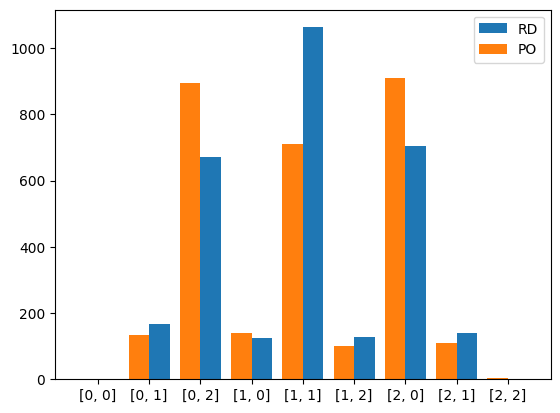

PyObject <matplotlib.legend.Legend object at 0x7f890b35cbe0>

In [8]:
function gen_plots(N,n,m,params)
        
    y_rd, x_rd = gen_data(N;n=n,m=m,params=params,select_eq=risk_dom,rand_x=false)
    y_po, x_po = gen_data(N;n=n,m=m,params=params,select_eq=pareto_opt,rand_x=false)
    
    labels = enum_eq([[]],n,m)

    no_labels = length(labels)
    pr_po = zeros(no_labels)
    pr_rd = zeros(no_labels)

    for i=1:no_labels
        for j=1:N
            if labels[i] == y_rd[:,j]
                pr_rd[i] = pr_rd[i]+1
            end
            if labels[i] == y_po[:,j]
                pr_po[i] = pr_po[i]+1
            end
        end
    end

    bar(collect(1:no_labels).+ .2, pr_rd,label="RD",width=.4)
    bar(collect(1:no_labels).- .2, pr_po,label="PO",width=.4)
    xticks(collect(1:no_labels),labels)
    legend()
end

gen_plots(3000,2,3,[-1.5,-1.5, 3.5, 3.5])

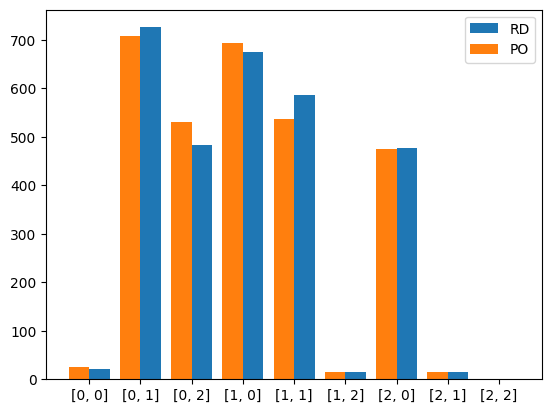

PyObject <matplotlib.legend.Legend object at 0x7f890aac1320>

In [9]:
gen_plots(3000,2,3,[-1.5,-1.5, 2.5, 2.5])

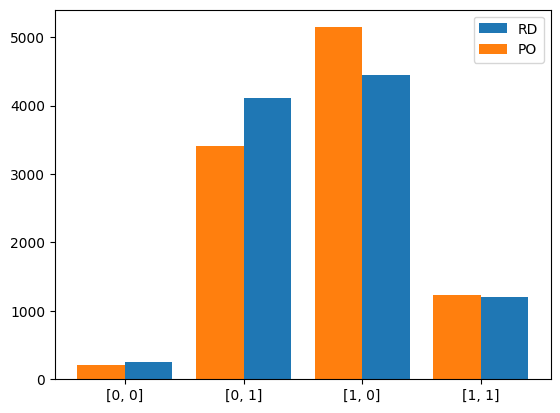

PyObject <matplotlib.legend.Legend object at 0x7f890a9cb358>

In [10]:
gen_plots(10000,2,2,[-2.2,-.9, 2.7, 1.7])